In [1]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import asyncio

In [64]:
class DataCollector:
    def __init__(self):
        self.cap = fdr.StockListing('KRX-MARCAP')
        self.cap = self.cap.loc[:, ['Code', 'Marcap']]
        self.cap.set_index('Code', inplace=True)

    def getPrice(self, code: str):
        res = fdr.DataReader(code)['Close']
        return res

    def getMarketCap(self, code: str):
        return self.cap.loc[code]['Marcap']

    def getPriceList(self, code: list):
        res = pd.concat([self.getPrice(c) for c in code],axis=1)
        res.columns = code
        return res
    def getRtn(self, df: pd.DataFrame, gap: int):
        rtn = ((df.shift(gap) - df) / df).dropna()
        return rtn
    def getRtnCorr(self, df : pd.DataFrame):
        return df.corr()
    def getMarketCapList(self, code: list):
        res = pd.DataFrame([self.getMarketCap(c) for c in code]).T
        res.columns = code
        return res

In [65]:
dc = DataCollector()

In [66]:
prices = dc.getPriceList(['055550','003550','009200','000990','031440','009150','024110'])
prices

,055550,003550,009200,000990,031440,009150,024110
Date,,,,,,,
1998-08-27,NaN,NaN,NaN,NaN,NaN,NaN,5100.0
1998-08-28,NaN,NaN,NaN,NaN,NaN,NaN,5100.0
1998-09-01,NaN,8939.0,2374.0,4263.0,NaN,12549.0,5100.0
1998-09-02,NaN,9139.0,2334.0,4146.0,NaN,12594.0,5100.0
1998-09-03,NaN,9350.0,2302.0,4185.0,NaN,12594.0,5100.0
...,...,...,...,...,...,...,...
2022-11-23,36400.0,82900.0,2695.0,46700.0,49200.0,133500.0,10950.0
2022-11-24,37050.0,84200.0,2770.0,46700.0,48300.0,135500.0,11050.0
2022-11-25,36550.0,85000.0,2735.0,45950.0,48100.0,134000.0,11050.0


In [67]:
daily_shift = (prices - prices.shift(10))/prices.shift(10)
weekly_shift = (prices-prices.shift(20))/prices.shift(20)
monthly_shift = (prices-prices.shift(40))/prices.shift(40) #일 주 월별로 수익률 구한다

In [68]:
label_monthly_shift = monthly_shift.copy() 

In [69]:
for i in monthly_shift.index:
    label_monthly_shift.loc[i] = monthly_shift.loc[i] 
    

In [70]:
x_set = pd.concat([daily_shift,weekly_shift,monthly_shift],axis=1).loc['2003-01-01':'2022-09-25'] 

In [71]:
y_set = label_monthly_shift.shift(-1).loc['2003-01-01':]

In [72]:
y_set

,055550,003550,009200,000990,031440,009150,024110
Date,,,,,,,
2003-01-02,0.052859,-0.001358,-0.139767,-0.053968,0.044226,-0.034872,-0.096386
2003-01-03,0.086442,0.019059,-0.135364,-0.048000,0.012136,-0.043303,-0.083714
2003-01-06,-0.003892,-0.025691,-0.145242,-0.074603,-0.018779,-0.096680,-0.121805
2003-01-07,-0.048338,0.002783,-0.121160,-0.077287,-0.002410,-0.081028,-0.123867
2003-01-08,-0.081500,-0.024995,-0.149153,-0.101881,-0.007246,-0.100402,-0.124424
...,...,...,...,...,...,...,...
2022-11-23,0.073913,0.102094,0.279446,0.166042,-0.072937,0.133891,0.155858
2022-11-24,0.067153,0.151762,0.305489,0.226969,-0.067829,0.180617,0.174283
2022-11-25,0.058309,0.128859,0.278571,0.262431,-0.069745,0.178571,0.138254


In [73]:
li = []
for i in prices.columns: #각 종목별로 있던 데이터 셋을 일렬로 쭉 나열함 column이 100x3 -> 100x1이었던것을 3 -> 1로 바꿈
    tmp = pd.concat([daily_shift.loc[:,i],weekly_shift.loc[:,i],monthly_shift.loc[:,i],y_set.loc[:,i]],axis=1).reset_index().drop(columns=['Date'])
    tmp.columns = ['daily','weekly','monthly','label']
    li.append(tmp)

In [74]:
df = pd.concat(li).reset_index().drop(columns=['index'])

In [75]:
df.dropna(inplace=True)

In [76]:
df

,daily,weekly,monthly,label
1077,-0.066436,-0.109179,0.045466,0.052859
1078,-0.015213,-0.075017,0.052859,0.086442
1079,-0.029419,-0.050371,0.086442,-0.003892
1080,-0.075829,-0.033970,-0.003892,-0.048338
1081,-0.085733,-0.065708,-0.048338,-0.081500
...,...,...,...,...
42008,0.047619,0.083744,0.111111,0.138254
42009,0.037915,0.095000,0.138254,0.155858
42010,0.047393,0.057416,0.155858,0.174283
42011,0.037559,0.052381,0.174283,0.138254


In [77]:
import lightgbm as lgb
trainset = lgb.Dataset(df.iloc[:-30].loc[:,['daily','weekly','monthly']].to_numpy(),df.iloc[:-30].loc[:,['label']].to_numpy())

In [78]:
testset = lgb.Dataset(df.iloc[-30:].loc[:,['daily','weekly','monthly']].to_numpy(),df.iloc[-30:].loc[:,['label']].to_numpy())

In [79]:
# params = {'learning_rate' : 0.001, 'max_depth' : 16, 'boosting' : 'gbdt',
#           'objective' : 'regression', 'metric' : 'mse', 'is_training_metric': True,
#          'num_leaves': 144, 'feature_fraction' : 0.9, 'bagging_fraction' : 0.7, 'bagging_freq' : 5, 'seed': 2020}
# model = lgb.train(params,trainset,1000,testset,verbose_eval=100,early_stopping_rounds=100)
params = {'learning_rate' : 0.001, 'max_depth' : 16, 'boosting' : 'gbdt',
          'objective' : 'regression', 'metric' : 'mse', 'is_training_metric': True,
         'num_leaves': 100, 'feature_fraction' : 0.9, 'bagging_fraction' : 0.7, 'bagging_freq' : 5, 'seed': 2020}
model = lgb.train(params,trainset,1000,testset,verbose_eval=100,early_stopping_rounds=100)

C:\Users\bjm77\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\bjm77\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\bjm77\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 34438, number of used features: 3
[LightGBM] [Info] Start training from score 0.021286
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.00607397
[200]	valid_0's l2: 0.00508868
[300]	valid_0's l2: 0.00427534
[400]	valid_0's l2: 0.00360527
[500]	valid_0's l2: 0.0030528
[600]	valid_0's l2: 0.00259626
[700]	valid_0's l2: 0.00221803
[800]	valid_0's l2: 0.00190421
[900]	valid_0's l2: 0.00164436
[1000]	valid_0's l2: 0.0014306
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0014306


In [80]:
tmprice = prices.iloc[-60:]

In [81]:
tdaily = (tmprice - tmprice.shift(10)) / tmprice.shift(10)
tweekly = (tmprice - tmprice.shift(20)) / tmprice.shift(20)
tmonthly = (tmprice - tmprice.shift(40)) / tmprice.shift(40)

In [82]:
tdaily.iloc[-1]

055550    0.014946
003550   -0.004700
009200    0.070588
000990   -0.082653
031440   -0.026531
009150   -0.059441
024110    0.032710
Name: 2022-11-29 00:00:00, dtype: float64

In [83]:
tmpsample = pd.concat([tdaily.iloc[-1],tweekly.iloc[-1],tmonthly.iloc[-1]],axis=1)
tmpsample.columns = ["daily","weekly","monthly"]
tmpsample

,daily,weekly,monthly
055550,0.014946,0.024691,0.114925
003550,-0.004700,0.040541,0.144595
009200,0.070588,0.107505,0.287736
000990,-0.082653,0.021591,0.203481
031440,-0.026531,0.008457,-0.046000
009150,-0.059441,0.111570,0.200893
024110,0.032710,0.057416,0.160714


In [84]:
model.predict(tmpsample)

array([ 0.07669642,  0.09424969,  0.18199817,  0.12835284, -0.02027411,
        0.13328767,  0.10802241])

In [86]:
tdaily.iloc[1].name

Timestamp('2022-09-02 00:00:00')

In [87]:
resli = []
for i in range(len(tdaily)-1):
    tmpsample = pd.concat([tdaily.iloc[i],tweekly.iloc[i],tmonthly.iloc[i]],axis=1)
    resli.append(model.predict(tmpsample) - y_set.loc[tdaily.iloc[i].name])
    

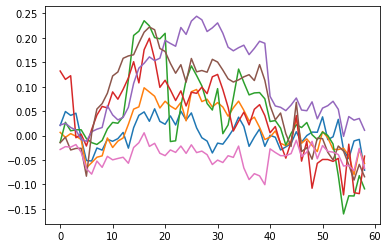

In [88]:
import matplotlib.pyplot as plt
plt.plot(resli)